In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader as pdr
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import requests_cache

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [2]:
class Security:

    def __init__(self, name, timeline):
        self.name = name
        self.transactions = pd.Series(0, name=self.name, index=timeline)
        self.timeline = timeline
        self.get_data()

    def get_data(self):
        df = pdr.yahoo.daily.YahooDailyReader(
        symbols=self.name,
        start=self.timeline[0],
        end=None,
        retry_count=3,
        pause=0.1,
        session=session,
        adjust_price=False,
        ret_index=False,
        chunksize=25,
        interval='d',
        get_actions=True,
        adjust_dividends=False).read()
        self.adj_prices = df['Adj Close'].reindex(index=self.timeline, method='nearest')
        split_adj_prices = df['Close'].reindex(index=self.timeline, method='nearest')
        if 'Dividends' in df.columns:
            self.dividends = df['Dividends'].reindex(index=self.timeline, fill_value=0).fillna(0)
        else:
            self.dividends = pd.Series(0, index=self.timeline)
        if 'Splits' in df.columns:
            split_coeff = df['Splits'].reindex(index=self.timeline, fill_value=1).fillna(1)
        else:
            split_coeff = pd.Series(1, index=self.timeline)

        self.prices = split_adj_prices / split_coeff.loc[::-1].cumprod()[::-1].shift(periods=-1, fill_value=1)
        self.splits = 1/split_coeff.cumprod()

    def update(self, date, amount):
        self.transactions.at[date] = self.transactions.at[date] + amount

    def run(self):
        self.holdings = self.transactions.cumsum() * self.splits
        self.holdings_value_locale = self.holdings * self.prices
        self.holdings_value = self.holdings_value_locale # / fx_rate
        self.holdings_dividend_locale = self.holdings * self.dividends
        self.holdings_dividend = self.holdings_dividend_locale # / fx_rate

In [3]:
class Account:

    def __init__(self, currency, timeline):
        self.name = 'CASH.' + currency
        self.internal_transactions = pd.Series(0, index=timeline)
        self.external_transactions = pd.Series(0, index=timeline)
    
    def internal_flow(self, date, amount):
        self.internal_transactions.at[date] = self.internal_transactions.at[date] + amount

    def external_flow(self, date, amount):
        self.external_transactions.at[date] = self.external_transactions.at[date] + amount

    def run(self):
        self.holdings = self.internal_transactions.cumsum()
        self.invested_capital = self.external_transactions.cumsum()

In [4]:
class Portfolio:
    
    def __init__(self, filename, currency='USD'):
        self.data = pd.read_csv(filename, sep=',', index_col='Date', parse_dates=True).sort_index()
        self.timeline = pd.date_range(start=self.data.index[0], end=datetime.date.today(), freq='B')
        self.currency = currency
        self.account = Account(self.currency, self.timeline)
        self.securities = dict() # dictionary with Security object at key='TICKER NAME'
        self._processed = False

    def run(self):
        if not self._processed:
            for date, transaction in self.data.iterrows():
                self.add_transaction(date, transaction)
            self.join_holdings()
            self.generate_stats()
        self._processed = True

    def add_transaction(self, date, transaction):
        # pick correct function without ifs
        getattr(self, transaction.Order)(date, transaction)
    
    def deposit(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, transaction.Quantity * transaction.Price)

    def withdrawal(self, date, transaction):
        self.account.internal_flow(date, - transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, - transaction.Quantity * transaction.Price)
    
    def purchase(self, date, transaction):
        self.account.internal_flow(date,- transaction.Quantity * transaction.Price - transaction.Fee ) # / fx_rate
        tick = self.securities.setdefault(transaction.Ticker, Security(transaction.Ticker, self.timeline))
        tick.update(date, transaction.Quantity)

    def sale(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee) # / fx_rate
        tick = self.securities.setdefault(transaction.Ticker, Security(transaction.Ticker, self.timeline))
        tick.update(date, - transaction.Quantity)

    def join_holdings(self):
        self.holdings = pd.DataFrame(index=self.timeline)
        for security in self.securities.values():
            security.run()
            self.account.internal_transactions = self.account.internal_transactions + security.holdings_dividend
            self.holdings = self.holdings.join(security.holdings_value.rename(security.name))
        self.account.run()
        self.holdings = self.holdings.join(self.account.holdings.rename(self.account.name))

    def generate_stats(self):
        self.value = self.holdings.sum(axis=1)
        self.daily_change = (self.value-self.account.external_transactions) - self.value.shift()
        self.daily_gross_ret = (self.value-self.account.external_transactions)/self.value.shift()
        self.daily_ret = self.daily_gross_ret - 1
        self.daily_log_ret = np.log(self.daily_gross_ret)
        self.std = self.daily_log_ret.std() * np.sqrt(252)
        self.exp_ret = self.daily_log_ret.mean() * 252
        self.sharpe = self.exp_ret/self.std
        self.semistd = self.daily_log_ret[self.daily_log_ret < self.daily_log_ret.mean()].std() * np.sqrt(252)
        self.sortino = self.exp_ret/self.semistd
        self.daily_var_5 = np.sort(self.daily_log_ret)[int(0.05*self.daily_log_ret.size)]*self.value[-1]
        self.daily_var_1 = np.sort(self.daily_log_ret)[int(0.01*self.daily_log_ret.size)]*self.value[-1]
        self.pl = self.value - self.account.invested_capital
        self.pctpl = self.pl / self.account.invested_capital
        self.cash_flows = - self.account.external_transactions
        self.cash_flows.iloc[-1] = self.cash_flows.iloc[-1] + self.value.iloc[-1]

    def benchmark(self, ticker):
        bench = Security(ticker, self.timeline).adj_prices
        return pd.concat({
            'Portfolio': self.pctpl,
            ticker: (bench/bench[0]-1),
        }, axis=1)

In [5]:
port = Portfolio('/Users/simoneprecicchiani/GitHub/PyPortfolioAnalytics/assets/portfolios/generic.csv')

In [6]:
port.run() # takes 3.2 seconds on MBA M1

<AxesSubplot:ylabel='Holding ($)'>

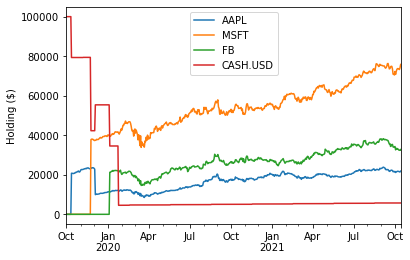

In [7]:
port.holdings.plot(ylabel='Holding ($)')

<AxesSubplot:ylabel='Return (%)'>

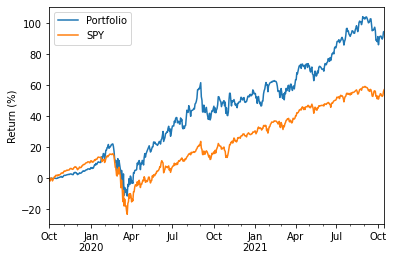

In [8]:
(port.benchmark('SPY')*100).plot(ylabel='Return (%)')

In [9]:
print(f'Last day return: ${round(port.daily_change[-1],2)}')
print(f'Last day return: {round(port.daily_ret[-1]*100,2)}%')

Last day return: $152.16
Last day return: 0.11%


In [10]:
print(f'Portfolio Value: ${round(port.value[-1],2)}')
print(f'P/L on invested capital: ${round(port.pl[-1],2)}')
print(f'P/L % on invested capital: {round(port.pctpl[-1]*100,2)}%')

Portfolio Value: $136276.46
P/L on invested capital: $66276.46
P/L % on invested capital: 94.68%


In [11]:
print(f'Annual Expected Return: {round(port.exp_ret,2)*100}%')
print(f'Annual Volatility: {round(port.std,2)*100}%')
print(f'Sharpe Ratio: {round(port.sharpe,2)}')
print(f'Sortino Ratio: {round(port.sortino,2)}')

Annual Expected Return: 30.0%
Annual Volatility: 30.0%
Sharpe Ratio: 1.0
Sortino Ratio: 1.2


<AxesSubplot:ylabel='Frequency'>

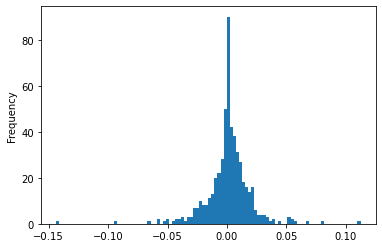

In [12]:
port.daily_log_ret.plot.hist(bins=100)

<AxesSubplot:ylabel='Log Returns'>

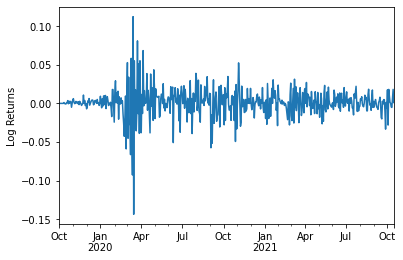

In [13]:
port.daily_log_ret.plot(ylabel='Log Returns')

In [14]:
print(f'1-day VaR, 95% confidence: ${abs(port.daily_var_5)}')
print(f'1-day VaR, 99% confidence: ${abs(port.daily_var_1)}')

1-day VaR, 95% confidence: $3721.053980828223
1-day VaR, 99% confidence: $7028.986854372941
